In [1]:
import pandas as pd
import geopandas as gpd
import folium
import rasterio
%matplotlib inline

import numpy as np
import rasterio as rio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
shipwrecks = gpd.read_file('data/shipwrecks.shp')


In [3]:
shipwrecks.head()

,Wreck_no,Name,Status,Lat,Long,Depth,Position_q,DD_Lat,DD_Long,geometry
0,5217.0,UNKNOWN,LIVE,54 47’.250,005 35’.067,78,Unreliable,54.787500,-5.584450,POINT (719597.353 6076495.399)
1,5155.0,TIBERIA,LIVE,54 46’.671,005 38’.829,24,Precisely known,54.777850,-5.647150,POINT (715619.079 6075227.524)
2,64129.0,AZURE,LIVE,54 46’.046,005 39’.025,35,Precisely known,54.767433,-5.650417,POINT (715464.468 6074059.029)
3,5152.0,CHIRRIPO,LIVE,54 45’.921,005 40’.761,11.6,Precisely known,54.765350,-5.679350,POINT (713614.991 6073738.779)
4,5147.0,ROSE II,LIVE,54 44’.271,005 38’.829,16.4,Precisely known,54.737850,-5.647150,POINT (715831.927 6070779.089)


In [4]:
print(shipwrecks.bounds)

             minx          miny           maxx          maxy
0   719597.352875  6.076495e+06  719597.352875  6.076495e+06
1   715619.079394  6.075228e+06  715619.079394  6.075228e+06
2   715464.468203  6.074059e+06  715464.468203  6.074059e+06
3   713614.990723  6.073739e+06  713614.990723  6.073739e+06
4   715831.927340  6.070779e+06  715831.927340  6.070779e+06
5   718330.147607  6.070845e+06  718330.147607  6.070845e+06
6   710593.208499  6.068542e+06  710593.208499  6.068542e+06
7   719719.586056  6.068581e+06  719719.586056  6.068581e+06
8   723594.087340  6.068578e+06  723594.087340  6.068578e+06
9   714389.153928  6.066096e+06  714389.153928  6.066096e+06
10  717195.314459  6.064777e+06  717195.314459  6.064777e+06
11  709212.681788  6.068168e+06  709212.681788  6.068168e+06
12  709763.111966  6.064417e+06  709763.111966  6.064417e+06


In [5]:
m = shipwrecks.explore ('Name')


In [6]:
%matplotlib inline

import numpy as np
import rasterio as rio
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [18]:
dataset = rio.open('data/slope.tif')

In [661]:
print('{} opened in {} mode'.format(dataset.name,dataset.mode))
print('image has {} band(s)'.format(dataset.count))
print('image size (width, height): {} x {}'.format(dataset.width, dataset.height))
print('band 1 dataype is {}'.format(dataset.dtypes[0])) # note that the band name (Band 1) differs from the list index [0]

data/slope.tif opened in r mode
image has 1 band(s)
image size (width, height): 11261 x 9342
band 1 dataype is int8


In [662]:
print(dataset.bounds)

BoundingBox(left=703686.5583486365, bottom=6060230.699536502, right=726208.5583486365, top=6078914.699536502)


In [663]:
print(dataset.crs)

EPSG:32629


In [664]:
print(dataset.transform)

| 2.00, 0.00, 703686.56|
| 0.00,-2.00, 6078914.70|
| 0.00, 0.00, 1.00|


In [665]:
img = dataset.read()

In [666]:
print(img.shape) # returns a tuple with the number of image bands bands, image height, and image width.
print(img[0]) # will return an IndexError, because while there are 7 bands, the indices range from 0 to 6.

(1, 9342, 11261)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [667]:
print(img[0, dataset.height // 2, dataset.width // 2]) # note that // performs floor division, as indices have to be integers

1


In [668]:
centeri, centerj = dataset.height // 2, dataset.width // 2 # note that centeri corresponds to the row, and centerj the column
centerx, centery = dataset.transform * (centerj, centeri) # note the reversal here, from i,j to j,i
print(dataset.index(centerx, centery))
print((centeri, centerj) == dataset.index(centerx, centery)) # check that these are the same

(4671, 5630)
True


In [669]:
top, lft = dataset.index(centerx-500, centery+500)
bot, rgt = dataset.index(centerx+500, centery-500)

subset = dataset.read(window=((top, bot), (lft, rgt))) # format is (top, bottom), (left, right)

dataset.close() # remember to close the dataset now that we're done with it.

In [670]:
with rio.open('data/slope.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

In [671]:
dataset

<closed DatasetReader name='data/slope.tif' mode='r'>

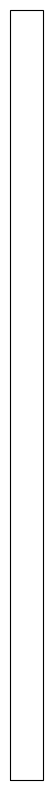

In [672]:
myCRS = ccrs.UTM(29) # note that this matches with the CRS of our image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

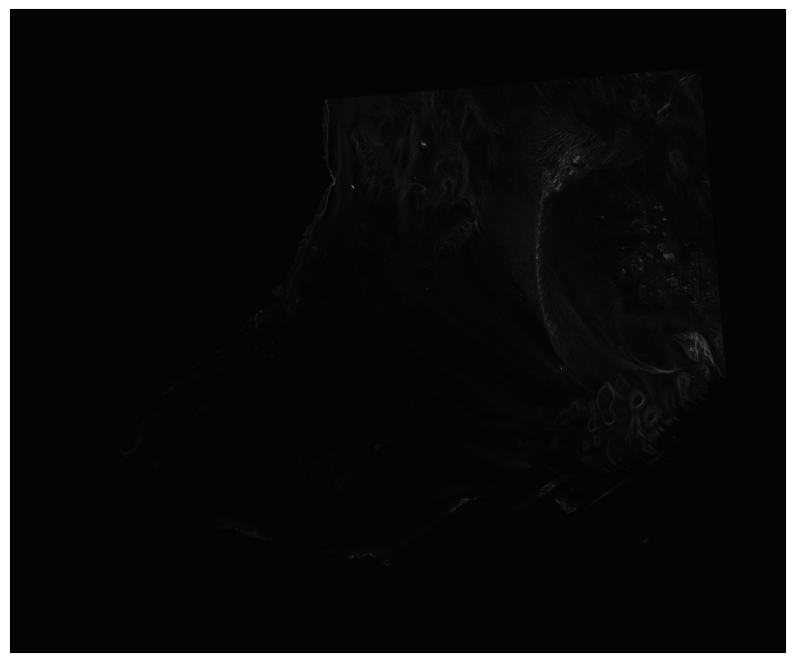

In [673]:
ax.imshow(img[0], cmap='gray', vmin=-1, vmax=62.6969, transform=myCRS, extent=[xmin, xmax, ymin, ymax])

fig

In [674]:
def img_display(image, ax, bands, transform, extent):
    '''
    This is where you should write a docstring.
    '''
    # first, we transpose the image to re-order the indices
    dispimg = image.transpose([1, 2, 0])
    
    # next, we have to scale the image.
    dispimg = dispimg / dispimg.max()
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

In [675]:
def percentile_stretch(image, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
    
    minval = np.percentile(image, pmin)
    maxval = np.percentile(image, pmax)
    
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
    
    return stretched

In [676]:
def img_display(image, ax, bands, transform, extent, pmin=0, pmax=100):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        dispimg[b] = percentile_stretch(image[b], pmin=pmin, pmax=pmax)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

In [677]:
h, ax = img_display(img, ax, [0], myCRS, [xmin, xmax, ymin, ymax], pmin=0.1, pmax=99.9)
fig # just to save you from scrolling back up to see

MemoryError: Unable to allocate 803. MiB for an array with shape (9342, 11261) and data type float64

In [678]:
def new_img_display(image, ax, bands, stretch_args=None, **imshow_args):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        if stretch_args is None: # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(image[b])
        else:
            dispimg[b] = percentile_stretch(image[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)
    
    return handle, ax

In [679]:
import rasterio.warp # note: we will be able to use rio.warp here, since we've previously imported rasterio as rio.
dst_crs = 'epsg:2157' # irish transverse mercator EPSG code

with rio.open('data/slope.tif') as src:
    transform, width, height = rio.warp.calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy() # this copies the meta dict object
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    }) # note: to change the values in a dictionary, we use the update() method
    
    with rio.open('data/slopec_ITM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1): # ranging from 1 to the number of bands + 1
            rio.warp.reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rio.warp.Resampling.nearest)

In [7]:
slopeimg = 'http://localhost:8888/view/Documents/uni%20work/egm722assignment/egm722assignment/data/slope12.png'

In [8]:
slopeimg_overlay = folium.raster_layers.ImageOverlay(name='slope', image='data/slope12.png',
                                               bounds = [[54.647546, -5.819697], [54.806823, -5.502818]])
                                               
                                              

In [9]:
slopeimg_overlay.add_to(m)



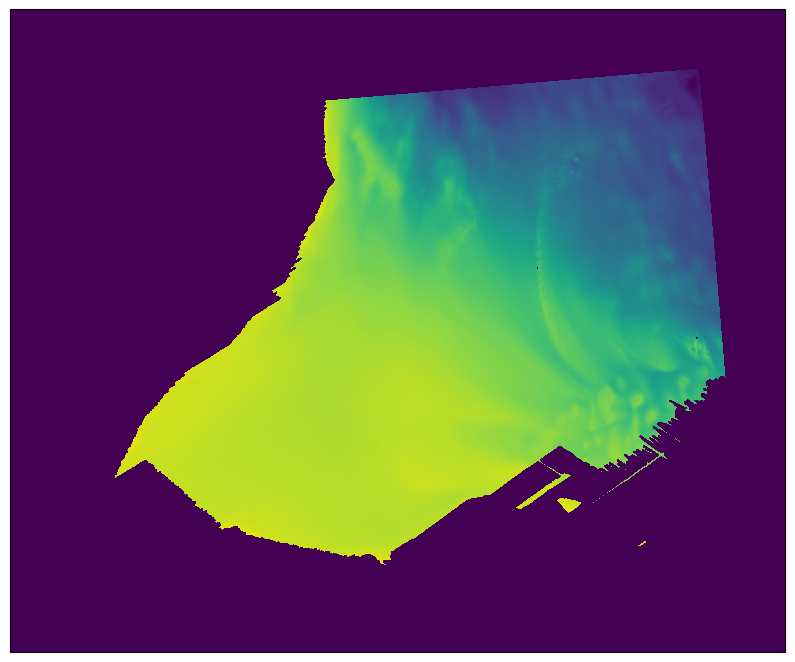
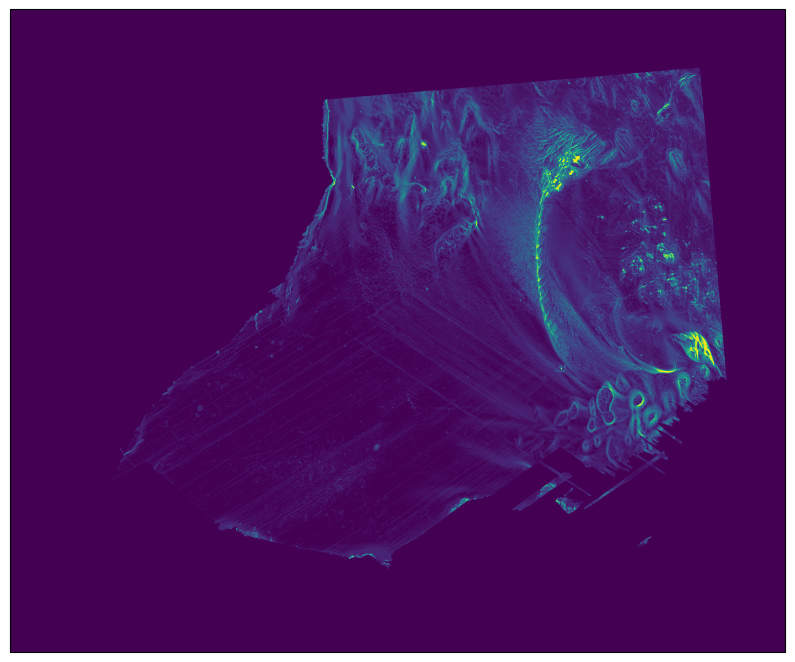
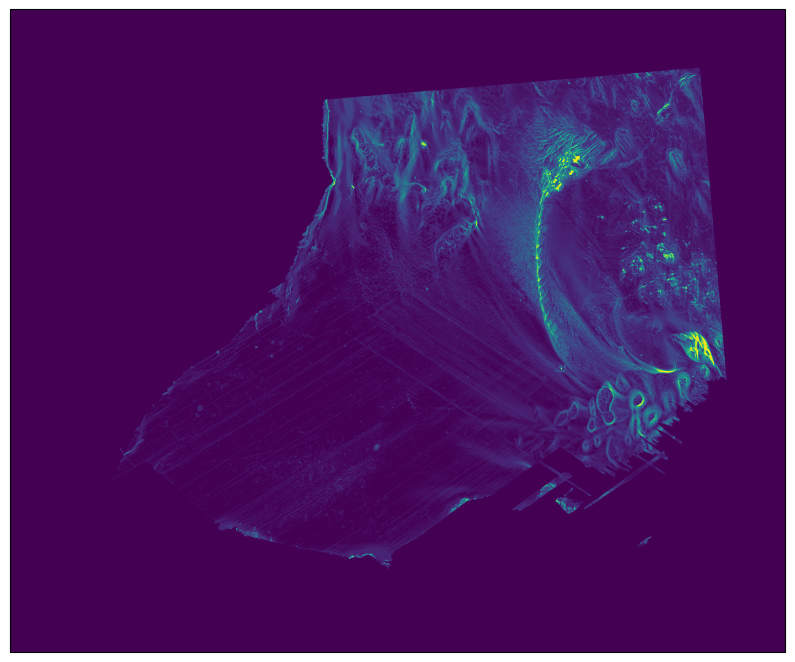

In [35]:
m

In [10]:
bathimg = 'http://localhost:8888/view/Documents/uni%20work/egm722assignment/egm722assignment/data/Bathymetry.png'

In [11]:
bathimg_overlay = folium.raster_layers.ImageOverlay(name='bathmetry', image='data/Bathymetry.png',
                                               bounds = [[54.647546, -5.819697], [54.806823, -5.502818]])

In [12]:
bathimg_overlay.add_to(m)

In [13]:
folium.LayerControl().add_to(m)


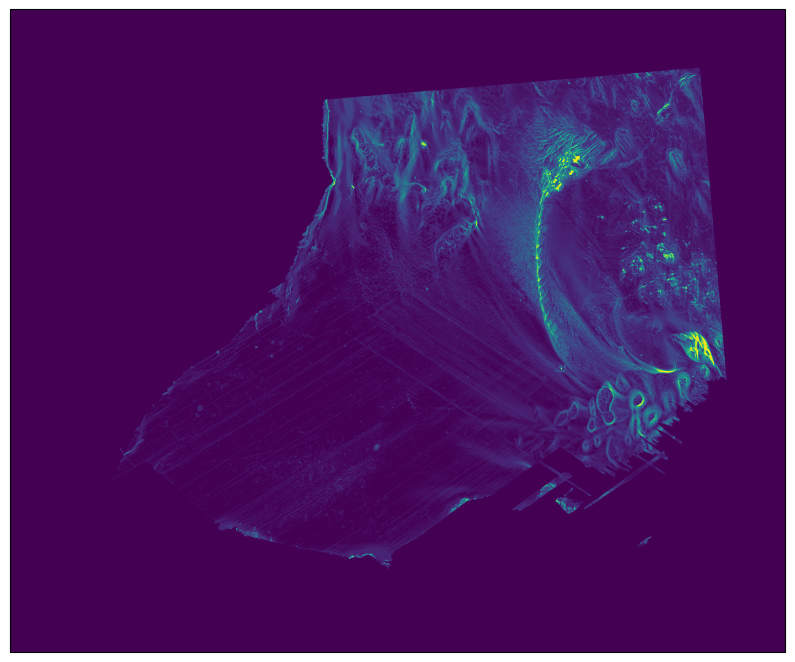
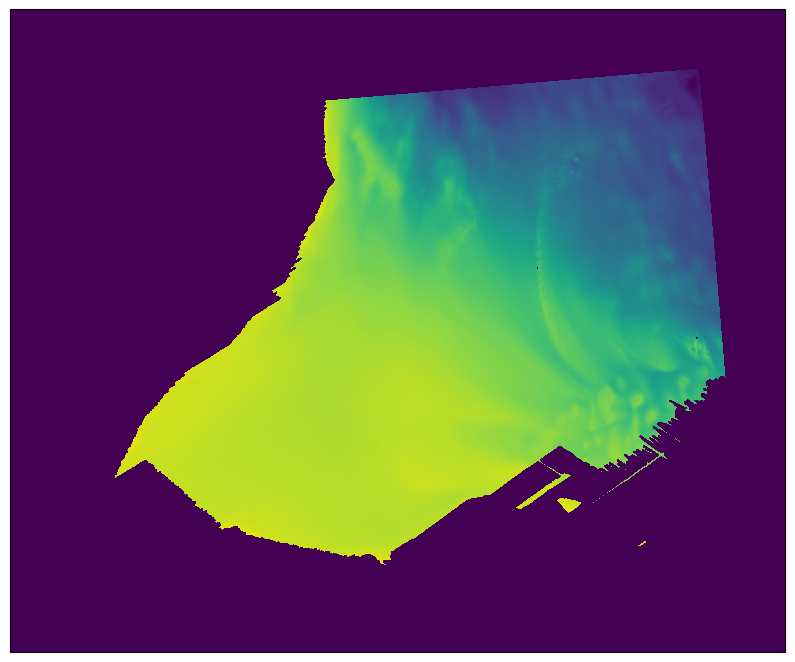

In [14]:
(m)